In [1]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import tqdm
import pickle
import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr, mode
from scipy.signal import argrelextrema, savgol_filter, medfilt
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit, minimize

import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)

import celerite
from celerite import terms
import autograd.numpy as anp

from tinygp import kernels, GaussianProcess

from pytisean import tiseano, tiseanio

In [2]:
matplotlib.rcParams['font.family'] = ['serif']

In [3]:
speculoos = np.genfromtxt("./speculoos_style_M8.txt") #Teff = 2592; Prot = 0.21265815403868307 d

#For now, don't worry about the scattered few speculoos obs taken post-covid 
speculoos_trunc = speculoos[(speculoos[:,0] < 2458247)]

kepler = np.genfromtxt("./kepler_style_G4.txt")       #Teff = 5687; Prot = 26.536163091164116 d (but evolving)
tess = np.genfromtxt("./TESS_style_F8.txt")           #Teff = 6060; Prot ~= 2.8 - 5.6 d (evolving)

print(np.shape(speculoos))
print(np.shape(kepler))
print(np.shape(tess))

(7275, 3)
(64887, 4)
(205351, 4)


(6788,)
(6788,)


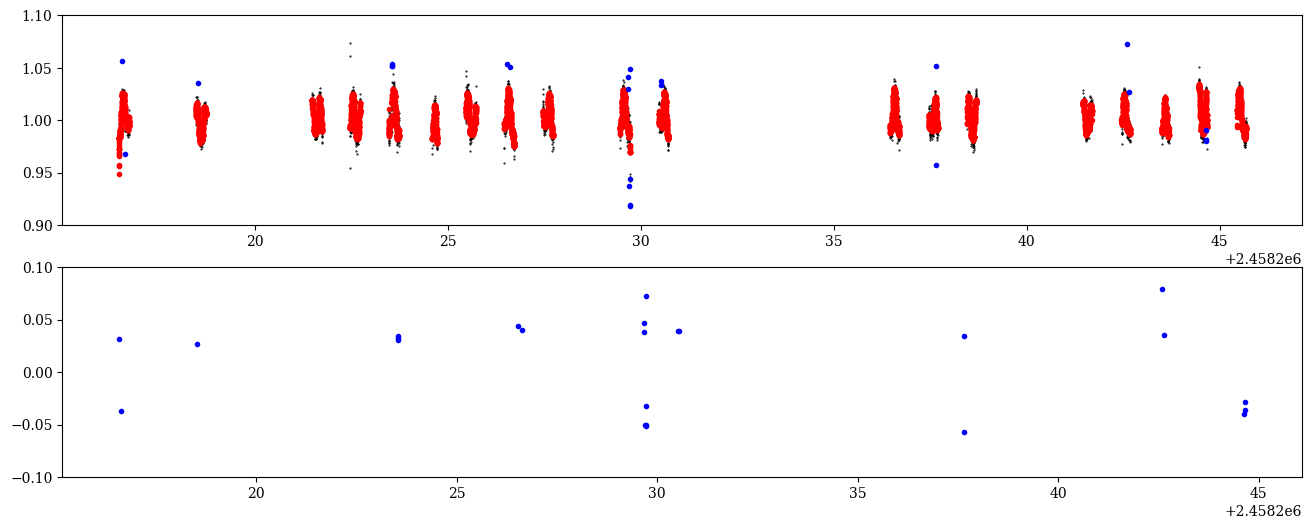

30
0.00441956393635828
6758


In [4]:
# eliminate speculoos flux outliers
movingmed = medfilt(speculoos_trunc[:,1], kernel_size = 15) #chose this kernel size as covering ~0.05*Prot
print(np.shape(movingmed))
print(np.shape(speculoos_trunc[:,1]))

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(speculoos_trunc[:,0],speculoos_trunc[:,1],'k.',ms=1,zorder=1)
axes[0].plot(speculoos_trunc[:,0],movingmed,'r.',zorder=2)
axes[0].set_ylim(0.9,1.1)


outlierMask = (np.abs(speculoos_trunc[:,1] - movingmed) > 5.*speculoos_trunc[:,2])

axes[0].plot(speculoos_trunc[:,0][outlierMask],speculoos_trunc[:,1][outlierMask],'b.',zorder=3)

axes[1].plot(speculoos_trunc[:,0][outlierMask],speculoos_trunc[:,1][outlierMask]-movingmed[outlierMask],'b.')
axes[1].set_ylim(-0.1,0.1)
plt.show()

print(len(speculoos_trunc[:,0][outlierMask]))
print(len(speculoos_trunc[:,0][outlierMask])/len(speculoos_trunc[:,0]))

speculoos_trunc = speculoos_trunc[~outlierMask]
print(len(speculoos_trunc))

(64887,)
(64887,)


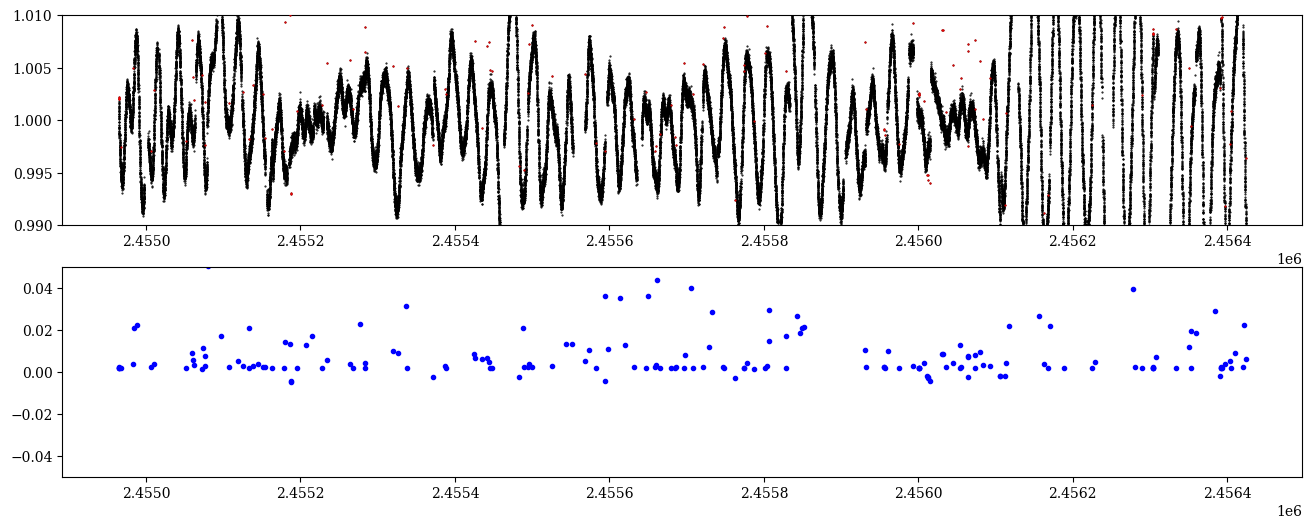

191
0.0029435788370551883
64696


In [5]:
# eliminate kepler flux outliers
movingmed = medfilt(kepler[:,1],kernel_size=65) #chose this kernel size as covering ~0.05*Prot
print(np.shape(movingmed))
print(np.shape(kepler[:,1]))

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(kepler[:,0],kepler[:,1],'k.',ms=1,zorder=1)
#axes[0].plot(kepler[:,0],movingmed,'r.',zorder=2)
axes[0].set_ylim(0.99,1.01)


outlierMask = (np.abs(kepler[:,1] - movingmed) > 5.*kepler[:,2])

axes[0].plot(kepler[:,0][outlierMask],kepler[:,1][outlierMask],'r.',ms=1,zorder=3)

axes[1].plot(kepler[:,0][outlierMask],kepler[:,1][outlierMask]-movingmed[outlierMask],'b.')
axes[1].set_ylim(-0.05,0.05)
plt.show()

print(len(kepler[:,0][outlierMask]))
print(len(kepler[:,0][outlierMask])/len(kepler[:,0]))

kepler = kepler[~outlierMask]
print(len(kepler))

(205351,)
(205351,)


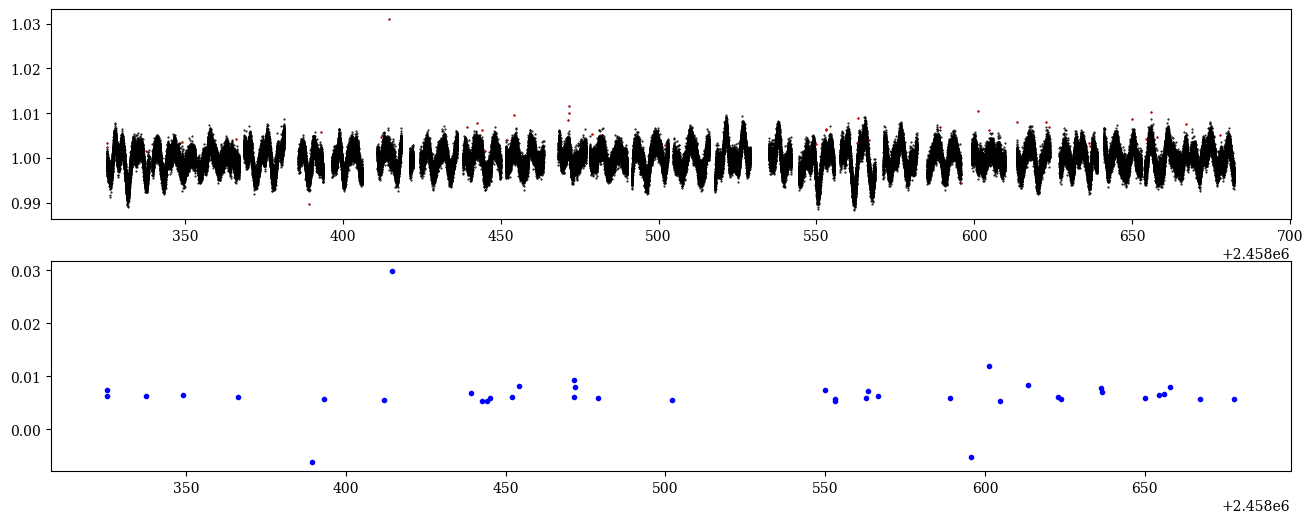

41
0.0001996581462958544
205310


In [6]:
# eliminate tess flux outliers
movingmed = medfilt(tess[:,1],kernel_size=201) #chose this kernel size as covering ~0.05*Prot
print(np.shape(movingmed))
print(np.shape(tess[:,1]))

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(tess[:,0],tess[:,1],'k.',ms=1,zorder=1)
#axes[0].plot(tess[:,0],tess,'r.',zorder=2)
#axes[0].set_ylim(0.99,1.01)


outlierMask = (np.abs(tess[:,1] - movingmed) > 5.*tess[:,2])

axes[0].plot(tess[:,0][outlierMask],tess[:,1][outlierMask],'r.',ms=1,zorder=3)

axes[1].plot(tess[:,0][outlierMask],tess[:,1][outlierMask]-movingmed[outlierMask],'b.')
#axes[1].set_ylim(-0.05,0.05)
plt.show()

print(len(tess[:,0][outlierMask]))
print(len(tess[:,0][outlierMask])/len(tess[:,0]))

tess = tess[~outlierMask]
print(len(tess))

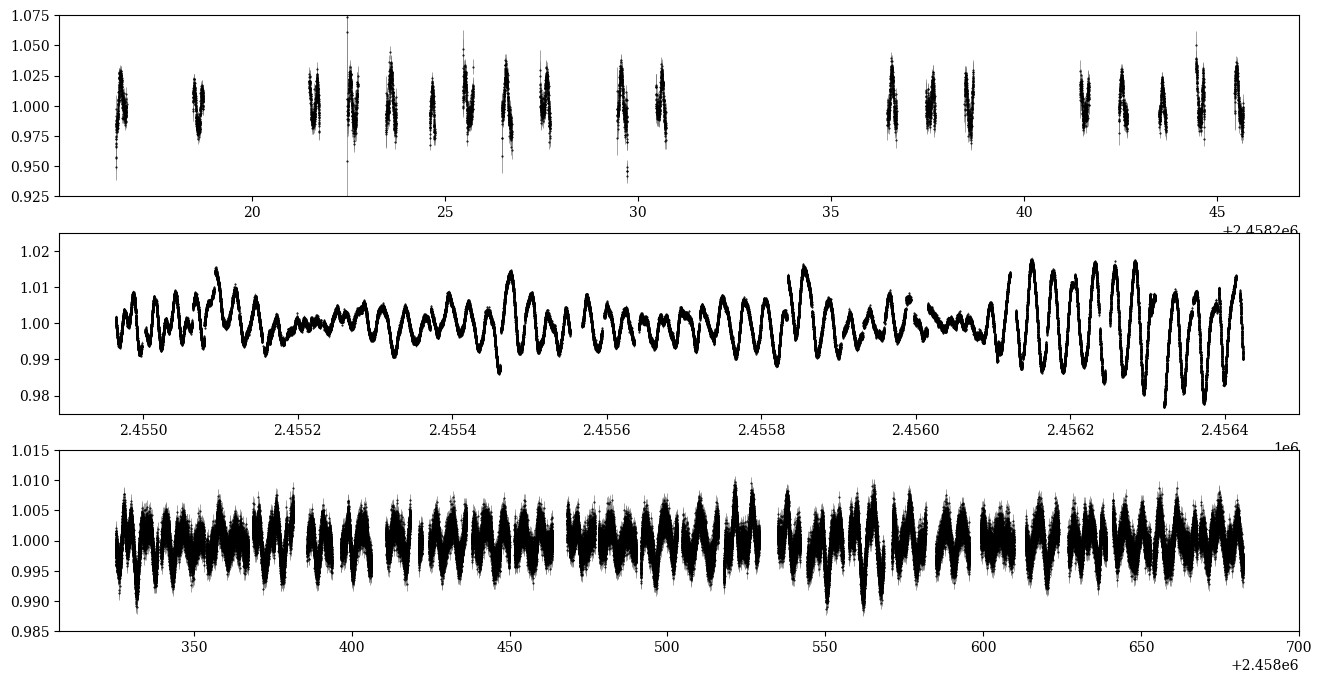

In [7]:
fig, axes = plt.subplots(3,1,figsize=(16,8))
#axes[0].errorbar(speculoos[:,0],speculoos[:,1],yerr=speculoos[:,2],color='k',ls='None',capsize=0)
axes[0].errorbar(speculoos_trunc[:,0],speculoos_trunc[:,1],yerr=speculoos_trunc[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')
axes[1].errorbar(kepler[:,0],kepler[:,1],yerr=kepler[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')
axes[2].errorbar(tess[:,0],tess[:,1],yerr=tess[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')

axes[0].set_ylim(0.925,1.075)
axes[1].set_ylim(0.975,1.025)
axes[2].set_ylim(0.985,1.015)

plt.show()

In [8]:
def find_cadence(timeseries):
    return mode(timeseries[1:] - timeseries[0:-1], keepdims=True)[0][0]

In [9]:
speculoos_trunc_cad = find_cadence(speculoos_trunc[:,0])
kepler_cad = find_cadence(kepler[:,0])
tess_cad = find_cadence(tess[:,0])

In [10]:
# best-fit periods from LS periodograms, in days
speculoos_Prot = 0.21265815403868307
kepler_Prot = 26.536163091164116
tess_Prot = 5.614166939523766

# 4. Rössler x,y,z

In [11]:
a=0.2
b=0.2
c=5.7

fp1, fp2 = sp.Rossler_FPs(a=0.2,b=0.2,c=5.7)
print(fp1)
print(fp2)

[  5.6929738  -28.46486898  28.46486898]
[ 0.0070262  -0.03513102  0.03513102]


In [12]:
r0 = np.array((1.,1.,1.))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
#r0 = np.array((-7.06916283,  0.71266172,  0.01578853))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r_init = np.empty((Nsteps,3))
rossler_t_init = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t_init[i] = rossler.t
    rossler_r_init[i] = rossler.y
    
    
print(rossler_r_init[5000])
'''
qp_x = sp.estimateQuasiPeriod(rossler_t_init, rossler_r_init[:,0])
qp_x_days = qp_x*dt

qp_y = sp.estimateQuasiPeriod(rossler_t_init, rossler_r_init[:,1])
qp_y_days = qp_y*dt

qp_z = sp.estimateQuasiPeriod(rossler_t_init, rossler_r_init[:,2])
qp_z_days = qp_z*dt

max_qp = np.max(np.array((qp_x,qp_y,qp_z)))
print(max_qp)
'''
max_qp = 628

[-7.06916283  0.71266172  0.01578853]


## Speculoos

In [13]:
r0 = np.array((-7.06916283,  0.71266172,  0.01578853))

#so we need ~321 data points per period, and we need to integrate for ~137 periods.
# fine to integrate at this higher cadence, can downsample later.
new_Nsteps = int(((speculoos_trunc[-1,0] - speculoos_trunc[0,0])*max_qp)/speculoos_Prot)
print(new_Nsteps)

rossler = RK45(fun=sp.Rossler_vel,t0=0.,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((new_Nsteps,3))
rossler_t = np.empty((new_Nsteps))
for i in range(new_Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y
    


86249


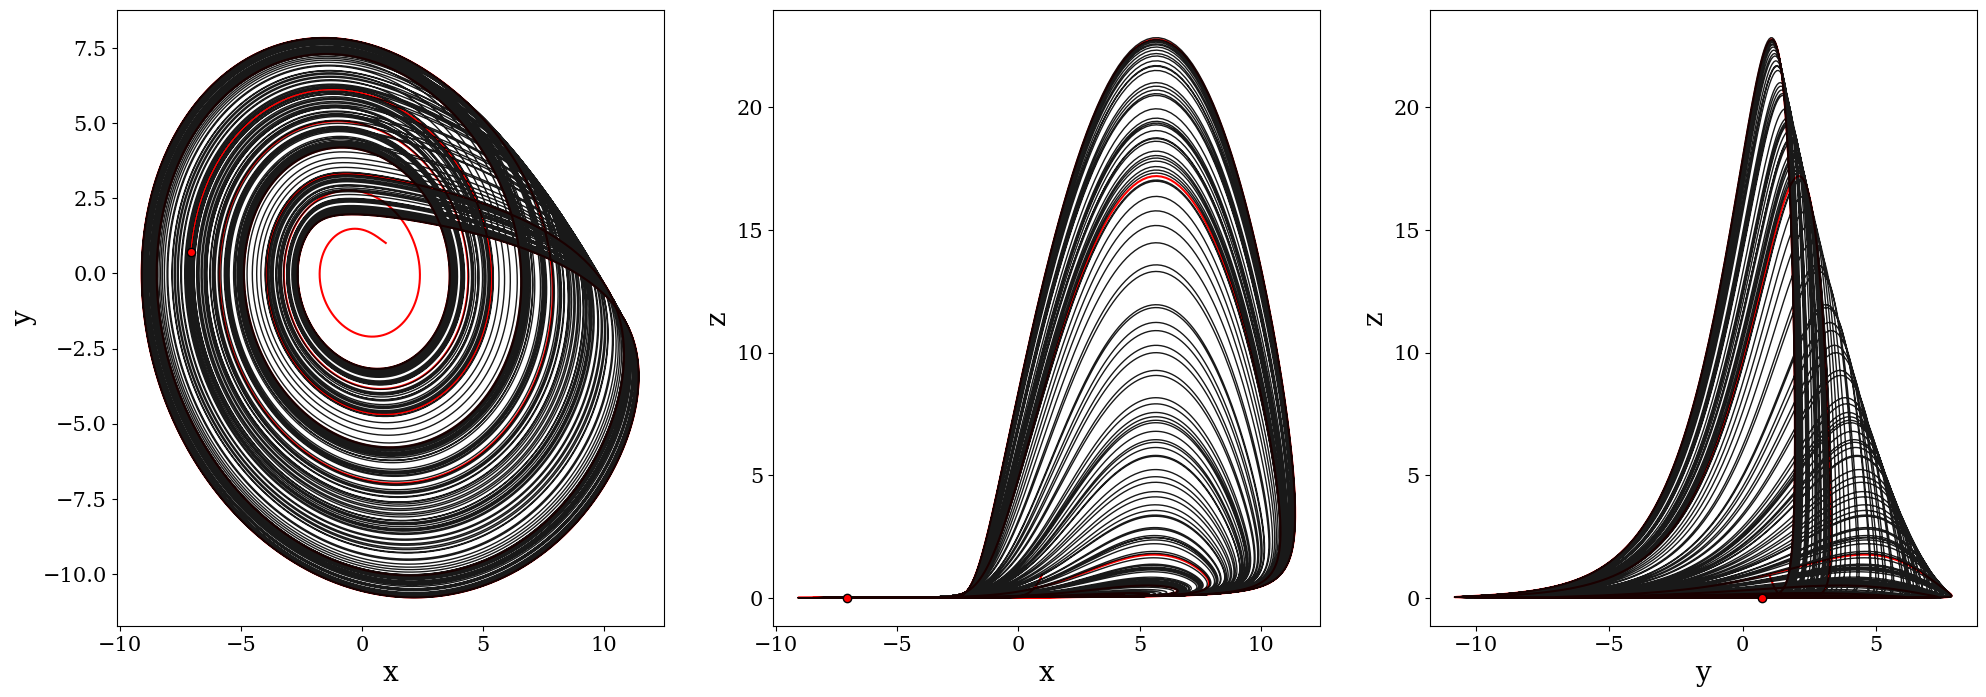

In [47]:
fig, axes = plt.subplots(1,3,figsize=(24,8))

axes[0].plot(rossler_r_init[:5000,0], rossler_r_init[:5000,1], 'r-')
axes[1].plot(rossler_r_init[:5000,0], rossler_r_init[:5000,2], 'r-')
axes[2].plot(rossler_r_init[:5000,1], rossler_r_init[:5000,2], 'r-')

axes[0].plot(rossler_r[:,0], rossler_r[:,1], 'k-',lw=1,alpha=0.9)
axes[1].plot(rossler_r[:,0], rossler_r[:,2], 'k-',lw=1,alpha=0.9)
axes[2].plot(rossler_r[:,1], rossler_r[:,2], 'k-',lw=1,alpha=0.9)

axes[0].plot(rossler_r_init[5000,0], rossler_r_init[5000,1], 'ro',mec='k')
axes[1].plot(rossler_r_init[5000,0], rossler_r_init[5000,2], 'ro',mec='k')
axes[2].plot(rossler_r_init[5000,1], rossler_r_init[5000,2], 'ro',mec='k')

axes[0].set_xlabel("x",fontsize=20)
axes[0].set_ylabel("y",fontsize=20)

axes[1].set_xlabel("x",fontsize=20)
axes[1].set_ylabel("z",fontsize=20)

axes[2].set_xlabel("y",fontsize=20)
axes[2].set_ylabel("z",fontsize=20)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

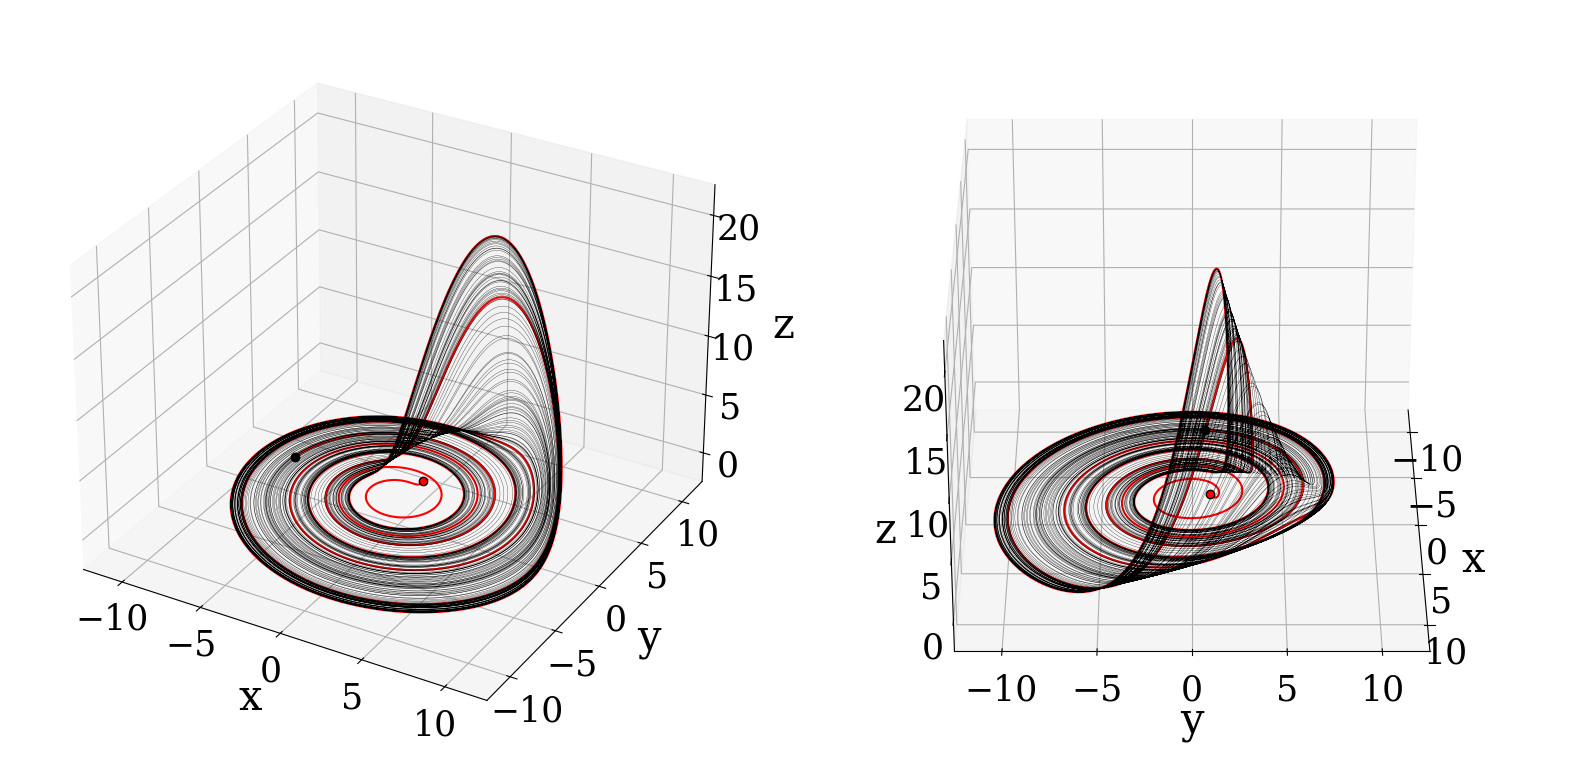

In [15]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
axes = np.array((ax1,ax2))
for ax in axes:
    ax.plot(rossler_r_init[:5000,0], rossler_r_init[:5000,1], rossler_r_init[:5000,2], 'r-')
    ax.plot(rossler_r[:,0], rossler_r[:,1], rossler_r[:,2], 'k-',lw=0.2,alpha=1)
    ax.plot(rossler_r_init[5000,0], rossler_r_init[5000,1], rossler_r_init[5000,2], 'ko',mec='k')
    ax.plot(1,1,1, 'ro',mec='k')

    ax.set_xlabel("x",fontsize=30,labelpad=14)
    ax.set_ylabel("y",fontsize=30,labelpad=14)
    ax.set_zlabel("z",fontsize=30,labelpad=14)

    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_zlim(-2,22)
    ax.tick_params(labelsize=25)
    ax.set_box_aspect(aspect=None, zoom=0.95)


axes[0].view_init(elev=30,azim=300,roll=0)
axes[1].view_init(elev=30, azim=360, roll=0)

plt.subplots_adjust(hspace=0.,wspace=0.05)
#plt.show()
plt.savefig("./rossler_init+speculoos_trajectory.pdf",bbox_inches="tight")

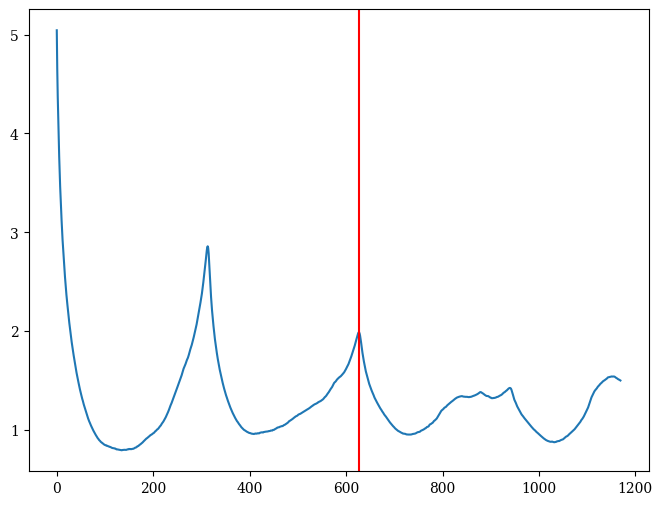

156
313
470
627


In [14]:
rossler_qp, rossler_MI = sp.estimateQuasiPeriod(time=rossler_t[:],timeSeries=rossler_r[:,0],plot=True,return_MI=True)
print(int(rossler_qp/4.))
print(int(rossler_qp/2.))
print(int((3*rossler_qp/4.)))
print(rossler_qp)

135
113
109


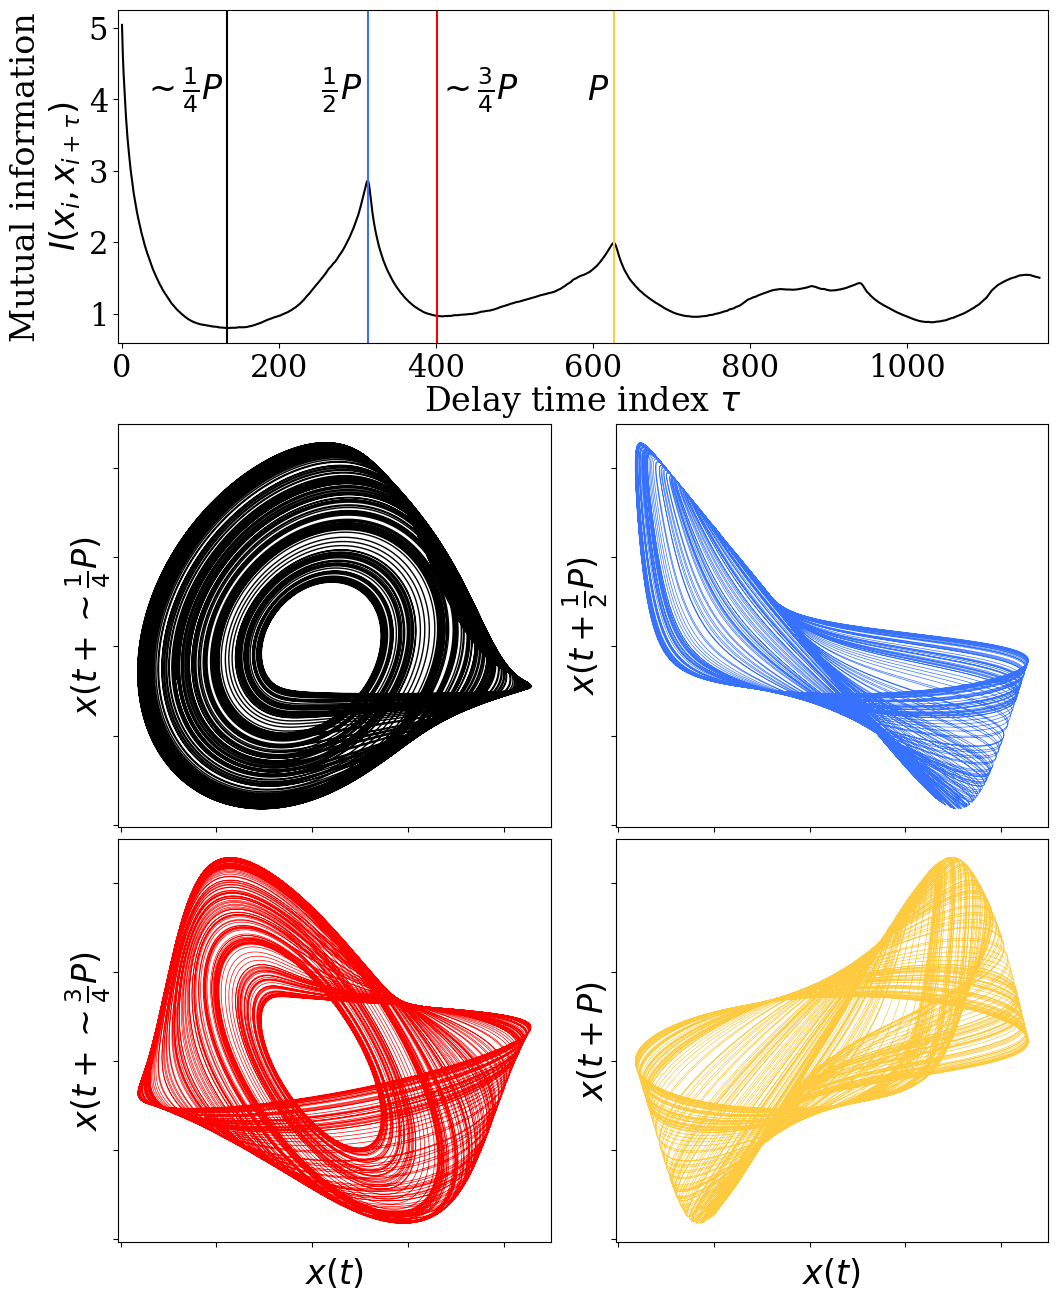

In [16]:
'''
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(rossler_t[1800:3600],rossler_r[1800:3600,0],color='b')
ax.plot(rossler_t[1800:3600],rossler_r[1800+156:3600+156,0],color='g') # +1/4 quasi-period = 1st local min of MI, 1st zero of autocorr. fn
ax.plot(rossler_t[1800:3600],rossler_r[1800+313:3600+313,0],color='m') # +1/2 quasi-period = 1st local max of MI, autocorr fn = -1
ax.plot(rossler_t[1800:3600],rossler_r[1800+470:3600+470,0],color='r') # +3/4 quasi-period = 2nd local min of MI, 2nd zero of autocorr. fn
ax.plot(rossler_t[1800:3600],rossler_r[1800+627:3600+627,0],color='y') #   +1 quasi-period = 2nd local max of MI, autocorr fn = +1
plt.show()
'''
print(np.argmin(rossler_MI[0:200]))        #134
print(np.argmax(rossler_MI[200:400]))      #113
print(np.argmin(rossler_MI[300:600]))      #101
'''
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(rossler_MI, 'k-')
ax.axvline(134,color='k')
ax.axvline(313,color='#3772ff')
ax.axvline(401,color='r')
ax.axvline(627,color='#fdca40')
ax.set_xlabel('Delay time index',fontsize=16)
ax.set_ylabel('Mutual information',fontsize=16)
ax.set_xlim(-5,1180)
plt.show()
'''

labelfontsize = 24
tickfontsize=22
fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(18,2,figure=fig)
MIax = fig.add_subplot(gs[0:5,:])

MIax.plot(rossler_MI, 'k-')
MIax.axvline(134,color='k')
MIax.axvline(313,color='#3772ff')
MIax.axvline(401,color='r')
MIax.axvline(627,color='#fdca40')
MIax.set_xlabel(r'Delay time index $\tau$',fontsize=labelfontsize,labelpad=0)
MIax.set_ylabel('Mutual information\n'+r'$I(x_i, x_{i+\tau})$',fontsize=labelfontsize)
MIax.set_xlim(-5,1180)
MIax.text(25,4,r"${\sim}\frac{1}{4}P$",fontsize=labelfontsize)
MIax.text(253,4,r"$\frac{1}{2}P$",fontsize=labelfontsize)
MIax.text(402,4,r"${\sim}\frac{3}{4}P$",fontsize=labelfontsize)
MIax.text(593,4,r"$P$",fontsize=labelfontsize)
MIax.tick_params(axis='both', which='major', labelsize=tickfontsize)

ax00 = fig.add_subplot(gs[6:12,0])
ax01 = fig.add_subplot(gs[6:12,1])
ax10 = fig.add_subplot(gs[12:,0])
ax11 = fig.add_subplot(gs[12:,1])
#axes[0].plot(rossler_r[0:3600,0],rossler_r[0:3600,0],'b')
ax00.plot(rossler_r[:-134,0],rossler_r[134:,0],'k',lw=0.5)
ax01.plot(rossler_r[:-313,0],rossler_r[313:,0],'#3772ff',lw=0.5)
ax10.plot(rossler_r[:-401,0],rossler_r[401:,0],'r',lw=0.5)
ax11.plot(rossler_r[:-627,0],rossler_r[627:,0],'#fdca40',lw=0.5)
for ax in [ax00,ax01,ax10,ax11]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for ax in [ax10,ax11]:
    ax.set_xlabel(r"$x(t)$",fontsize=labelfontsize)

ax00.set_ylabel(r"$x(t + {\sim}\frac{1}{4}P)$",fontsize=labelfontsize,labelpad=-3)
ax01.set_ylabel(r"$x(t + \frac{1}{2}P)$",fontsize=labelfontsize,labelpad=-3)
ax10.set_ylabel(r"$x(t + {\sim}\frac{3}{4}P)$",fontsize=labelfontsize,labelpad=-3)
ax11.set_ylabel(r"$x(t + P)$",fontsize=labelfontsize,labelpad=-3)
                                          
plt.subplots_adjust(hspace=0.21,wspace=0.15)
#plt.show()
plt.savefig("./phases.pdf", bbox_inches="tight")

In [16]:
print(rossler_t_init[0:5000])
print(rossler_t)

[-99.99 -99.98 -99.97 ... -50.02 -50.01 -50.  ]
[1.0000e-02 2.0000e-02 3.0000e-02 ... 8.6247e+02 8.6248e+02 8.6249e+02]


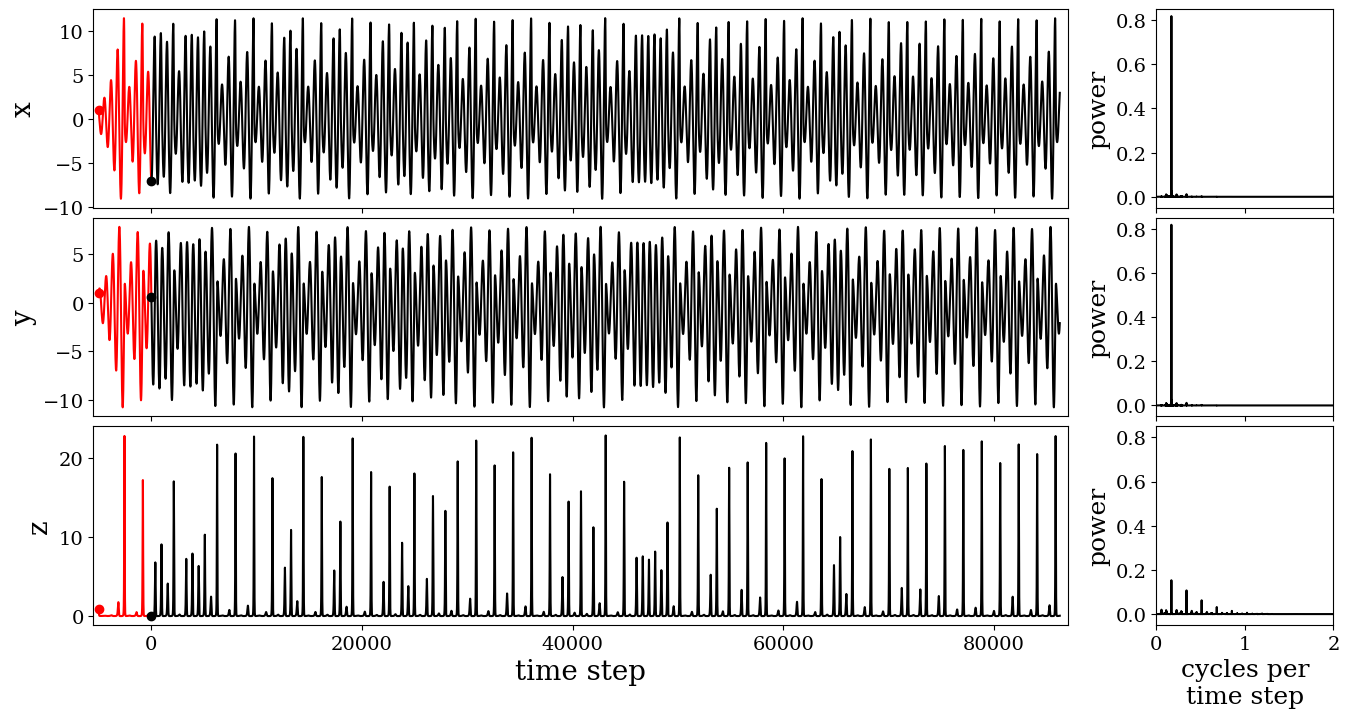

In [18]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(3,5)

xax = fig.add_subplot(gs[0,0:4])
yax = fig.add_subplot(gs[1,0:4])
zax = fig.add_subplot(gs[2,0:4])

xls = fig.add_subplot(gs[0,4])
yls = fig.add_subplot(gs[1,4])
zls = fig.add_subplot(gs[2,4])

axes = [xax,yax,zax]
for i in range(3):
    axes[i].plot((rossler_t_init[0]+50)/dt,rossler_r_init[0,i],'ro')
    axes[i].plot((rossler_t_init[:5000]+50)/dt,rossler_r_init[:5000,i],'r-')
    axes[i].plot((rossler_t[0])/dt, rossler_r[0,i],'ko')
    axes[i].plot(rossler_t/dt, rossler_r[:,i],'k-')

xax.set_ylabel("x",fontsize=20)
yax.set_ylabel("y",fontsize=20)
zax.set_ylabel("z",fontsize=20)

zax.set_xlabel("time step",fontsize=20)
xax.set_xticklabels([])
yax.set_xticklabels([])

for ax in axes:
    ax.tick_params(labelsize=14)
    ax.set_xlim(-55/dt,870/dt)

xfreq, xpow = LombScargle(rossler_t,rossler_r[:,0]).autopower(minimum_frequency=1./(rossler_t[-1] - rossler_t[0]), maximum_frequency=1./(2.*dt))
xls.plot(xfreq,xpow,'k-')
#xls.set_xlabel("cycles per time step, dt = 0.1",fontsize=20)
xls.set_ylabel("power",fontsize=18)

yfreq, ypow = LombScargle(rossler_t,rossler_r[:,1]).autopower(minimum_frequency=1./(rossler_t[-1] - rossler_t[0]), maximum_frequency=1./(2.*dt))
yls.plot(xfreq,xpow,'k-')
#yls.set_xlabel("cycles per time step, dt = 0.1",fontsize=20)
yls.set_ylabel("power",fontsize=18)

zfreq, zpow = LombScargle(rossler_t,rossler_r[:,2]).autopower(minimum_frequency=1./(rossler_t[-1] - rossler_t[0]), maximum_frequency=1./(2.*dt))
zls.plot(zfreq,zpow,'k-')
zls.set_xlabel("cycles per\ntime step",fontsize=18)
zls.set_ylabel("power",fontsize=18)

xls.set_xticklabels([])
yls.set_xticklabels([])
for ax in [xls,yls,zls]:
    ax.set_xlim(0.,2)
    ax.set_ylim(-0.05,0.85)
    ax.tick_params(labelsize=14)
    #ax.set_yscale("log")
    #ax.set_xscale("log")
 
plt.subplots_adjust(hspace=0.05,wspace=0.5)
#plt.show()
plt.savefig("./rossler_timeseries.pdf",bbox_inches="tight")

# 5. Transformed Rössler x,y,z

In [19]:
rossler_fp1 = np.array((0.0070262, -0.03513102, 0.03513102)) # central. strongly attractive in z, repulsive spiral in x, y
rossler_fp2 = np.array((5.6929738, -28.46486898, 28.46486898)) # outlying. repulsive in z, weak attractive spiral in x,y

transformed_rossler_fp1 = (1./np.sqrt(2))*np.array((rossler_fp1[1] + rossler_fp1[2], rossler_fp1[2] + rossler_fp1[0], rossler_fp1[0] + rossler_fp1[1]))
transformed_rossler_fp2 = (1./np.sqrt(2))*np.array((rossler_fp2[1] + rossler_fp2[2], rossler_fp2[2] + rossler_fp2[0], rossler_fp2[0] + rossler_fp2[1]))


r0 = (1.,1.,1.)
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
#r0 = np.array((3.6162099,  -5.17683558, -1.58314013))

# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

transformed_rossler = RK45(fun=sp.transformed_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

transformed_rossler_r_init = np.empty((Nsteps,3))
transformed_rossler_t_init = np.empty((Nsteps))
for i in range(Nsteps):
    transformed_rossler.step()
    transformed_rossler_t_init[i] = transformed_rossler.t
    transformed_rossler_r_init[i] = transformed_rossler.y

print(transformed_rossler_r_init[5000])
qp_x = sp.estimateQuasiPeriod(transformed_rossler_t_init, transformed_rossler_r_init[:,0])
qp_x_days = qp_x*dt

qp_y = sp.estimateQuasiPeriod(transformed_rossler_t_init, transformed_rossler_r_init[:,1])
qp_y_days = qp_y*dt

qp_z = sp.estimateQuasiPeriod(transformed_rossler_t_init, transformed_rossler_r_init[:,2])
qp_z_days = qp_z*dt

max_qp = np.max(np.array((qp_x,qp_y,qp_z)))

[ 3.6162099  -5.17683558 -1.58314013]


## Speculoos

In [20]:
r0 = np.array((3.6162099,  -5.17683558, -1.58314013))

new_Nsteps = int(((speculoos_trunc[-1,0] - speculoos_trunc[0,0])*max_qp)/speculoos_Prot)
print(new_Nsteps)

transformed_rossler = RK45(fun=sp.transformed_Rossler_vel,t0=0.,y0=r0,max_step=dt,t_bound=10000.)

transformed_rossler_r = np.empty((new_Nsteps,3))
transformed_rossler_t = np.empty((new_Nsteps))
for i in range(new_Nsteps):
    transformed_rossler.step()
    transformed_rossler_t[i] = transformed_rossler.t
    transformed_rossler_r[i] = transformed_rossler.y
    


86249


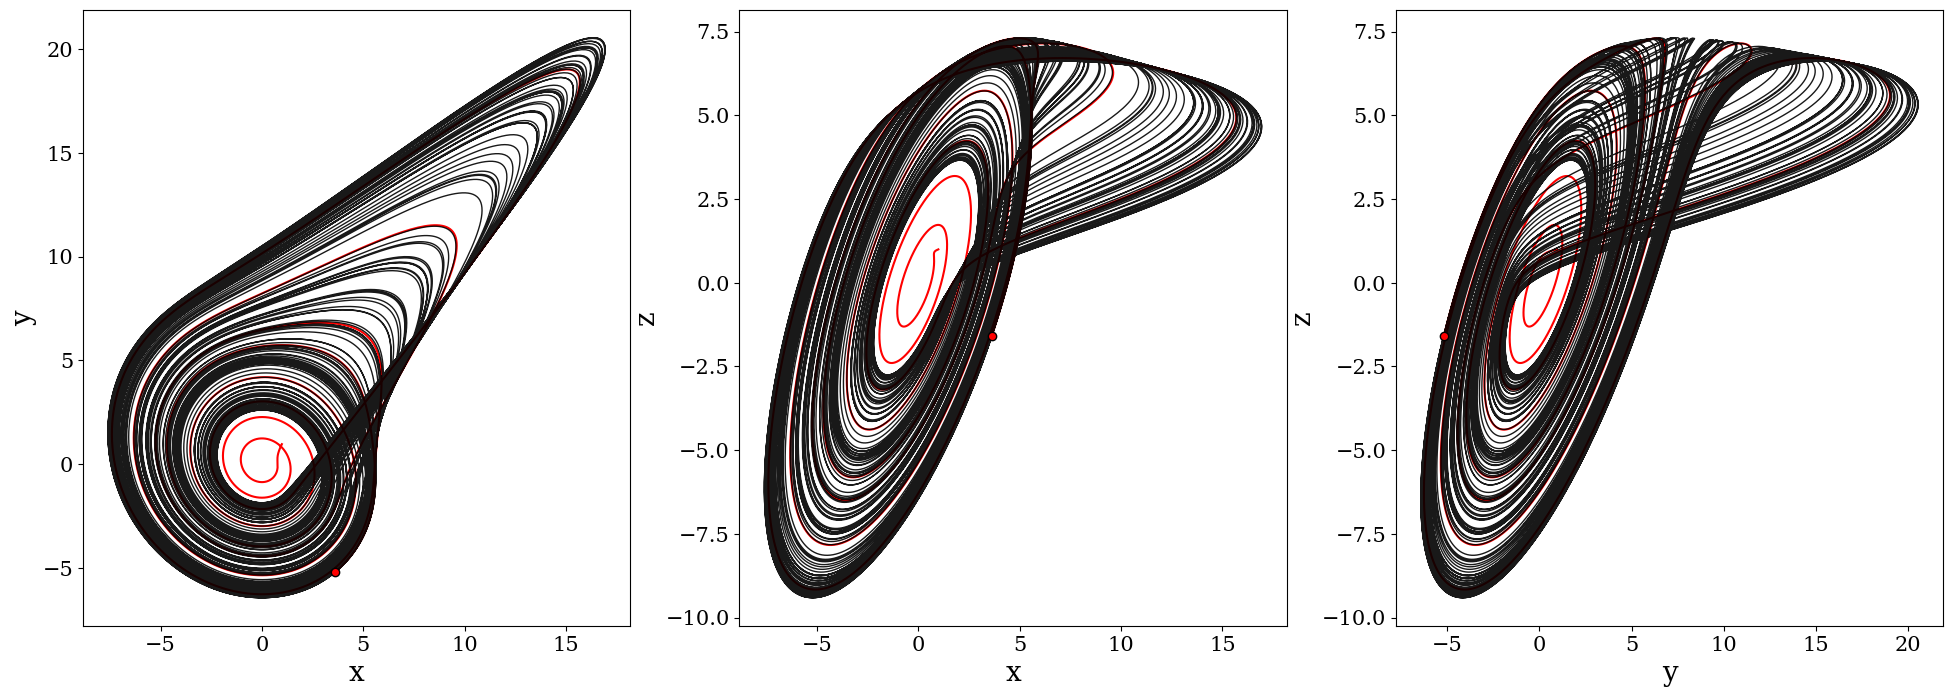

In [21]:
fig, axes = plt.subplots(1,3,figsize=(24,8))

axes[0].plot(transformed_rossler_r_init[:5000,0], transformed_rossler_r_init[:5000,1], 'r-')
axes[1].plot(transformed_rossler_r_init[:5000,0], transformed_rossler_r_init[:5000,2], 'r-')
axes[2].plot(transformed_rossler_r_init[:5000,1], transformed_rossler_r_init[:5000,2], 'r-')

axes[0].plot(transformed_rossler_r[:,0], transformed_rossler_r[:,1], 'k-',lw=1,alpha=0.9)
axes[1].plot(transformed_rossler_r[:,0], transformed_rossler_r[:,2], 'k-',lw=1,alpha=0.9)
axes[2].plot(transformed_rossler_r[:,1], transformed_rossler_r[:,2], 'k-',lw=1,alpha=0.9)

axes[0].plot(transformed_rossler_r_init[5000,0], transformed_rossler_r_init[5000,1], 'ro',mec='k')
axes[1].plot(transformed_rossler_r_init[5000,0], transformed_rossler_r_init[5000,2], 'ro',mec='k')
axes[2].plot(transformed_rossler_r_init[5000,1], transformed_rossler_r_init[5000,2], 'ro',mec='k')

axes[0].set_xlabel("x",fontsize=20)
axes[0].set_ylabel("y",fontsize=20)

axes[1].set_xlabel("x",fontsize=20)
axes[1].set_ylabel("z",fontsize=20)

axes[2].set_xlabel("y",fontsize=20)
axes[2].set_ylabel("z",fontsize=20)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

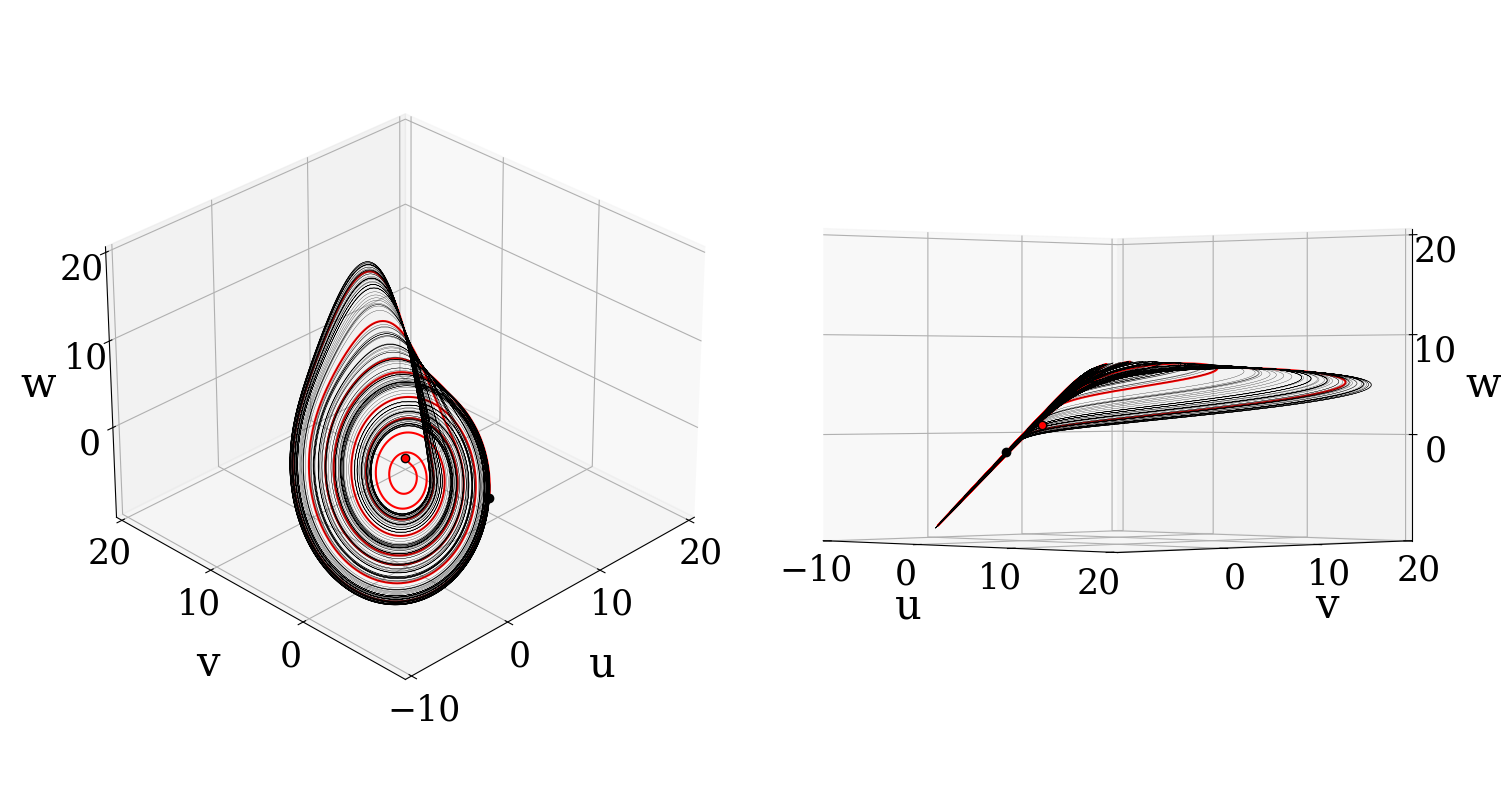

In [22]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
axes = np.array((ax1,ax2))
for ax in axes:
    ax.plot(transformed_rossler_r_init[:5000,0], transformed_rossler_r_init[:5000,1], transformed_rossler_r_init[:5000,2], 'r-')
    ax.plot(transformed_rossler_r[:,0], transformed_rossler_r[:,1], transformed_rossler_r[:,2], 'k-',lw=0.2,alpha=1)
    ax.plot(transformed_rossler_r_init[5000,0], transformed_rossler_r_init[5000,1], transformed_rossler_r_init[5000,2], 'ko',mec='k')
    ax.plot(1,1,1, 'ro',mec='k')

    ax.set_xlabel("u",fontsize=30,labelpad=25)
    ax.set_ylabel("v",fontsize=30,labelpad=25)
    ax.set_zlabel("w",fontsize=30,labelpad=15)
    ax.set_xticks([-10,0,10,20])
    ax.set_yticks([0,10,20])
    ax.set_zticks([0,10,20])
    
    ax.tick_params(labelsize=25)

    ax.set_xlim(-10,20)
    ax.set_ylim(-10,20)
    ax.set_zlim(-10,20)
    ax.set_box_aspect(aspect=None, zoom=0.84)

axes[1].set_xlabel("u",fontsize=30,labelpad=30)
axes[1].set_ylabel("v",fontsize=30,labelpad=30)
axes[1].set_zlabel("w",fontsize=30,labelpad=14)

axes[0].view_init(elev=30, azim=225, roll=0)
#axes[1].view_init(elev=30, azim=350, roll=0)
axes[1].view_init(elev=0,azim=315,roll=0)
plt.subplots_adjust(hspace=0.,wspace=-0.15)
plt.savefig("./transformed_rossler_init+speculoos_trajectory.pdf",bbox_inches="tight")

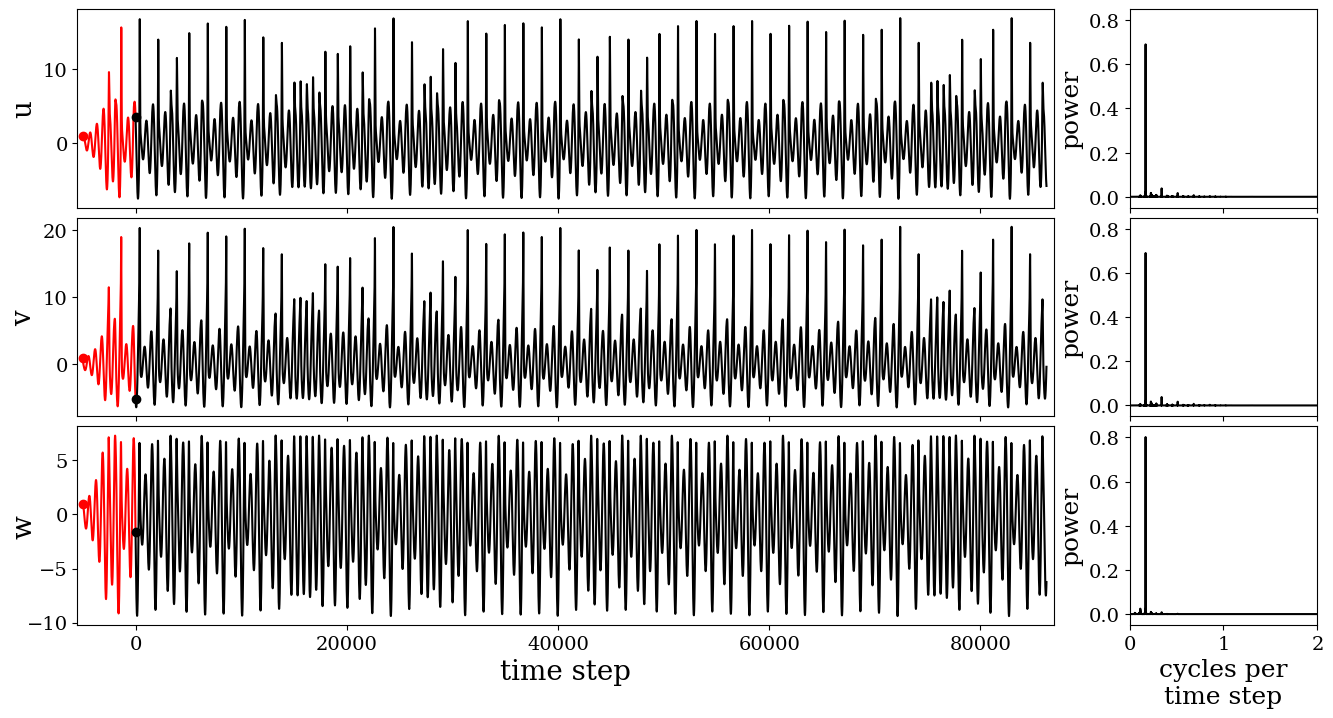

In [23]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(3,5)

xax = fig.add_subplot(gs[0,0:4])
yax = fig.add_subplot(gs[1,0:4])
zax = fig.add_subplot(gs[2,0:4])

xls = fig.add_subplot(gs[0,4])
yls = fig.add_subplot(gs[1,4])
zls = fig.add_subplot(gs[2,4])

axes = [xax,yax,zax]
for i in range(3):
    axes[i].plot((transformed_rossler_t_init[0]+50)/dt,transformed_rossler_r_init[0,i],'ro')
    axes[i].plot((transformed_rossler_t_init[:5000]+50)/dt,transformed_rossler_r_init[:5000,i],'r-')
    axes[i].plot(transformed_rossler_t[0]/dt, transformed_rossler_r[0,i],'ko')
    axes[i].plot(transformed_rossler_t/dt, transformed_rossler_r[:,i],'k-')

xax.set_ylabel("u",fontsize=20)
yax.set_ylabel("v",fontsize=20)
zax.set_ylabel("w",fontsize=20,labelpad=-7.5)

zax.set_xlabel("time step",fontsize=20)
xax.set_xticklabels([])
yax.set_xticklabels([])

for ax in axes:
    ax.tick_params(labelsize=14)
    ax.set_xlim(-55/dt,870/dt)

xfreq, xpow = LombScargle(transformed_rossler_t,transformed_rossler_r[:,0]).autopower(minimum_frequency=1./(transformed_rossler_t[-1] - transformed_rossler_t[0]), maximum_frequency=1./(2.*dt))
xls.plot(xfreq,xpow,'k-')
#xls.set_xlabel("cycles per time step, dt = 0.1",fontsize=20)
xls.set_ylabel("power",fontsize=18)

yfreq, ypow = LombScargle(transformed_rossler_t,transformed_rossler_r[:,1]).autopower(minimum_frequency=1./(transformed_rossler_t[-1] - transformed_rossler_t[0]), maximum_frequency=1./(2.*dt))
yls.plot(xfreq,xpow,'k-')
#yls.set_xlabel("cycles per time step, dt = 0.1",fontsize=20)
yls.set_ylabel("power",fontsize=18)

zfreq, zpow = LombScargle(transformed_rossler_t,transformed_rossler_r[:,2]).autopower(minimum_frequency=1./(transformed_rossler_t[-1] - transformed_rossler_t[0]), maximum_frequency=1./(2.*dt))
zls.plot(zfreq,zpow,'k-')
zls.set_xlabel("cycles per\ntime step",fontsize=18)
zls.set_ylabel("power",fontsize=18)

xls.set_xticklabels([])
yls.set_xticklabels([])
for ax in [xls,yls,zls]:
    ax.set_xlim(0.,2)
    ax.set_ylim(-0.05,0.85)
    ax.tick_params(labelsize=14)
    #ax.set_yscale("log")
    #ax.set_xscale("log")
 
plt.subplots_adjust(hspace=0.05,wspace=0.4)
#plt.show()
plt.savefig("./transformed_rossler_timeseries.pdf",bbox_inches="tight")

# 6. Lorenz x,y,z

In [24]:
r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
#r0 = np.array((-13.29390985, -16.32060497,  29.90864944))

#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r_init = np.empty((Nsteps,3))
lorenz_t_init = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t_init[i] = lorenz.t
    lorenz_r_init[i] = lorenz.y

print(lorenz_r_init[4000])
print(lorenz_r_init[5000])

lorenz_int = RK45(fun=sp.Lorenz_vel,t0=300.,y0=lorenz_r_init[4000],max_step=dt,t_bound=10000.)
Nsteps_int = int((500-300)/dt)
lorenz_r_int = np.empty((Nsteps_int,3))
lorenz_t_int = np.empty((Nsteps_int))
for i in range(Nsteps_int):
    lorenz_int.step()
    lorenz_t_int[i] = lorenz_int.t
    lorenz_r_int[i] = lorenz_int.y

print(lorenz_r_int[1000])

[-2.30943042 -2.62856373 18.70100069]
[ 1.45546919  2.64054038 17.86359415]
[ 1.57438502  2.77036798 17.43397087]


In [25]:
qp_x = sp.estimateQuasiPeriod(lorenz_t_init, lorenz_r_init[:,0],method="localMaxSep",cwt_widths=np.arange(5,100,5))
qp_x_days = qp_x*dt

qp_y = sp.estimateQuasiPeriod(lorenz_t_init, lorenz_r_init[:,1],method="localMaxSep",cwt_widths=np.arange(5,100,5))
qp_y_days = qp_y*dt

qp_z = sp.estimateQuasiPeriod(lorenz_t_init, lorenz_r_init[:,2])
qp_z_days = qp_z*dt

max_qp = np.max(np.array((qp_x,qp_y,qp_z)))

In [26]:
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))

new_Nsteps = int(((speculoos_trunc[-1,0] - speculoos_trunc[0,0])*max_qp)/speculoos_Prot)
print(new_Nsteps)

lorenz = RK45(fun=sp.Lorenz_vel,t0=0.,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((new_Nsteps,3))
lorenz_t = np.empty((new_Nsteps))
for i in range(new_Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y
    

10437


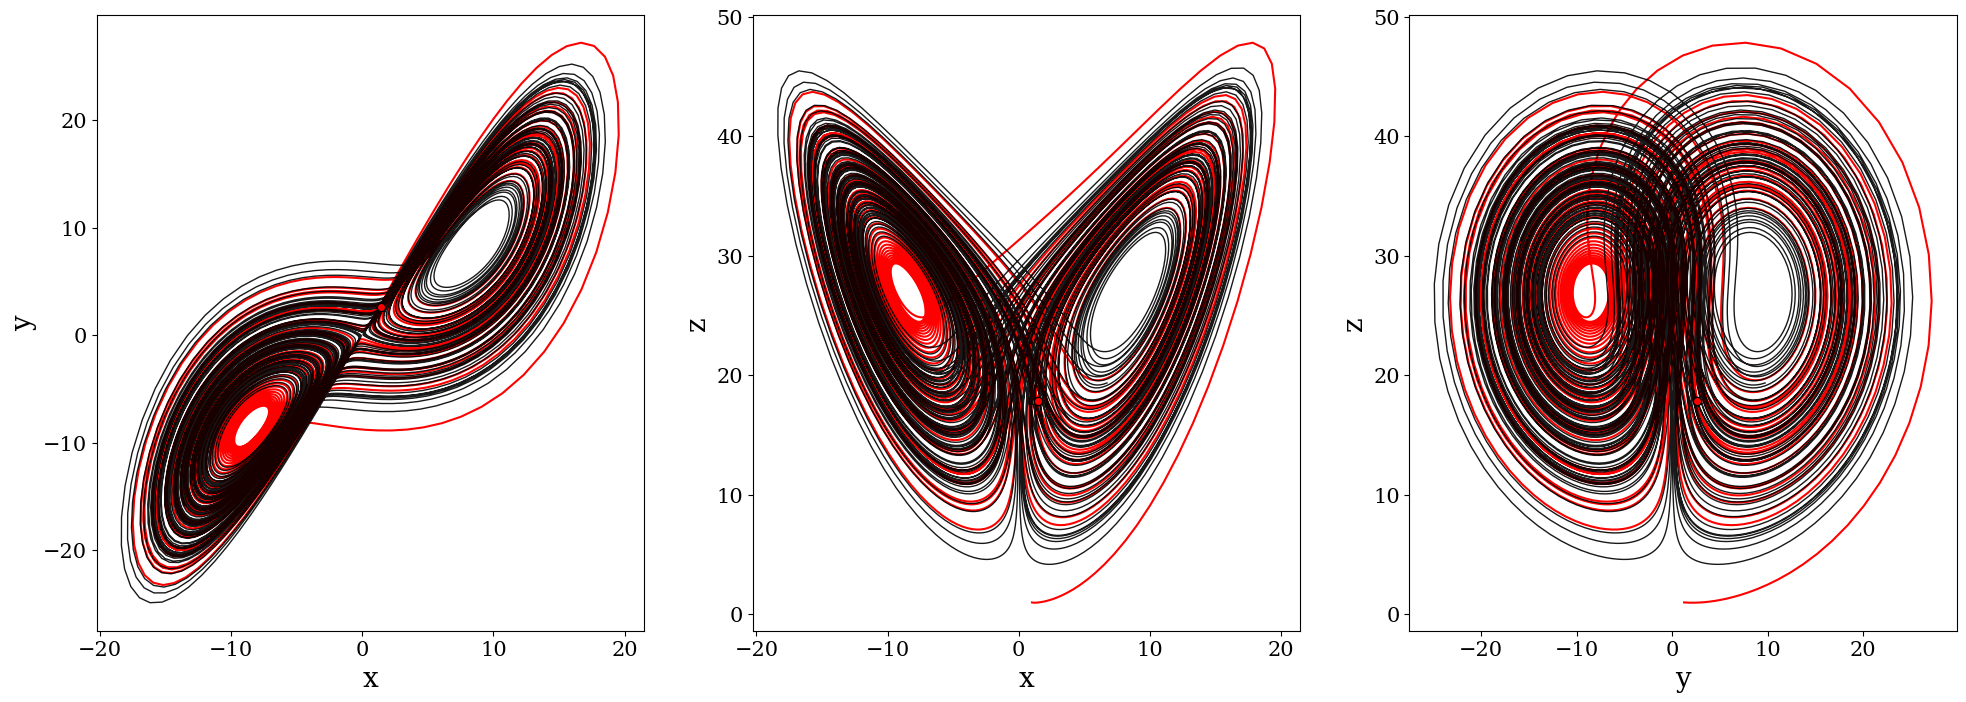

In [27]:
fig, axes = plt.subplots(1,3,figsize=(24,8))

axes[0].plot(lorenz_r_init[:5000,0], lorenz_r_init[:5000,1], 'r-')
axes[1].plot(lorenz_r_init[:5000,0], lorenz_r_init[:5000,2], 'r-')
axes[2].plot(lorenz_r_init[:5000,1], lorenz_r_init[:5000,2], 'r-')

axes[0].plot(lorenz_r[:,0], lorenz_r[:,1], 'k-',lw=1,alpha=0.9)
axes[1].plot(lorenz_r[:,0], lorenz_r[:,2], 'k-',lw=1,alpha=0.9)
axes[2].plot(lorenz_r[:,1], lorenz_r[:,2], 'k-',lw=1,alpha=0.9)

axes[0].plot(lorenz_r_init[5000,0], lorenz_r_init[5000,1], 'ro',mec='k')
axes[1].plot(lorenz_r_init[5000,0], lorenz_r_init[5000,2], 'ro',mec='k')
axes[2].plot(lorenz_r_init[5000,1], lorenz_r_init[5000,2], 'ro',mec='k')

axes[0].set_xlabel("x",fontsize=20)
axes[0].set_ylabel("y",fontsize=20)

axes[1].set_xlabel("x",fontsize=20)
axes[1].set_ylabel("z",fontsize=20)

axes[2].set_xlabel("y",fontsize=20)
axes[2].set_ylabel("z",fontsize=20)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

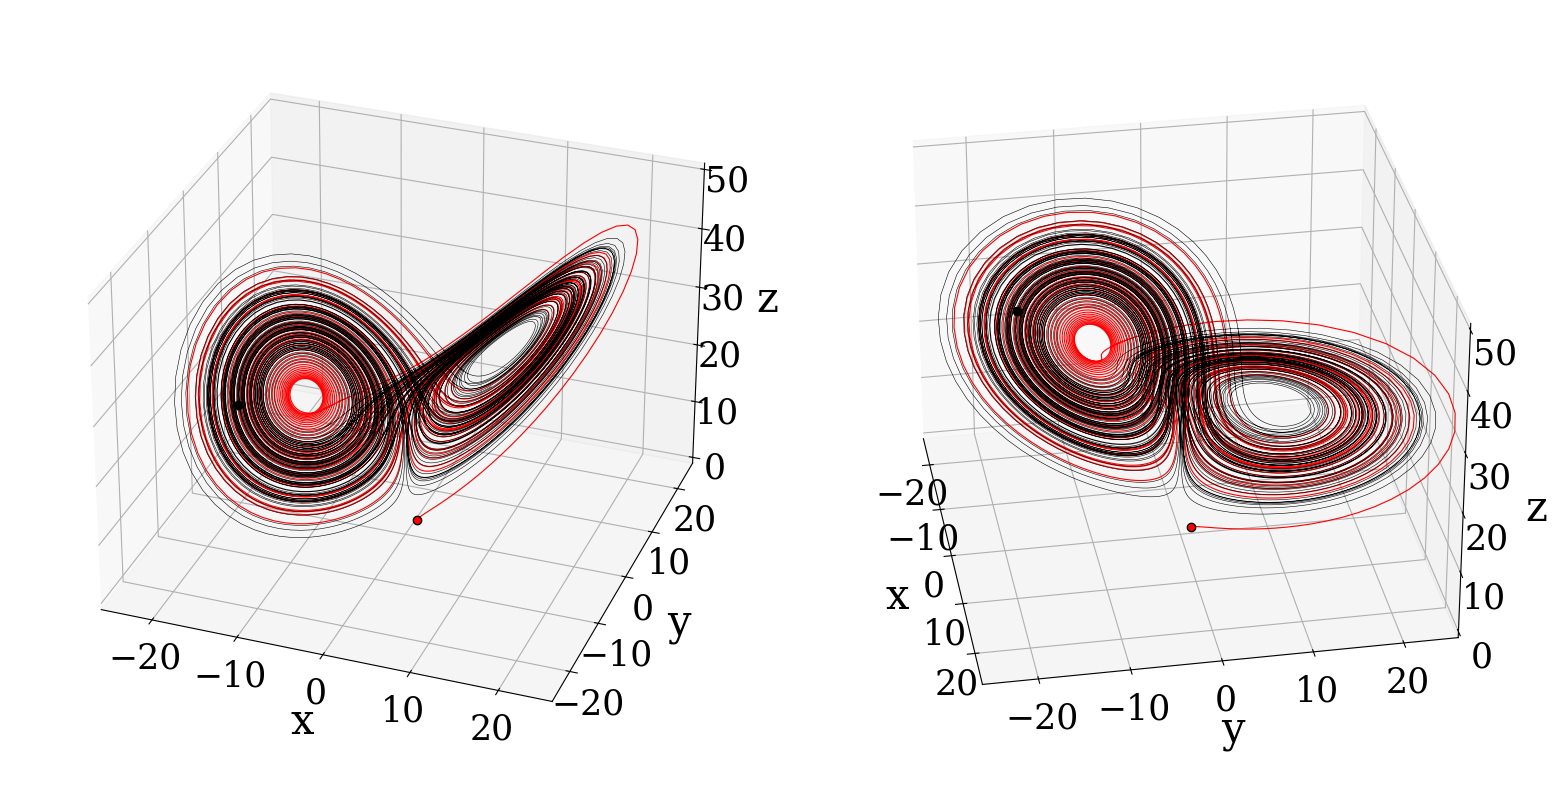

In [43]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
axes = np.array((ax1,ax2))
for ax in axes:
    ax.plot(lorenz_r_init[:4881,0], lorenz_r_init[:4881,1], lorenz_r_init[:4881,2], 'r-',lw=0.8,zorder=1)
    ax.plot(lorenz_r[:,0], lorenz_r[:,1], lorenz_r[:,2], 'k-',lw=0.4,alpha=1,zorder=2)
    ax.plot(np.array((-13.29390985,lorenz_r[0,0])), np.array((-16.32060497,lorenz_r[0,1])),np.array((29.90864944,lorenz_r[0,2])), 'k-',lw=0.4,alpha=1,zorder=3)
    ax.plot(-13.29390985,-16.32060497,29.90864944, 'ko',mec='k',zorder=4)
    ax.plot(1,1,1, 'ro',mec='k',zorder=5)

    ax.set_xlabel("x",fontsize=30,labelpad=14)
    ax.set_ylabel("y",fontsize=30,labelpad=14)
    ax.set_zlabel("z",fontsize=30,labelpad=14)

    ax.tick_params(labelsize=25)

    ax.set_xlim(-25,25)
    ax.set_ylim(-25,25)
    ax.set_zlim(-0,50)
    ax.set_box_aspect(aspect=None, zoom=0.95)

axes[0].view_init(elev=30, azim=290, roll=0)
axes[1].view_init(elev=30, azim=350, roll=0)
plt.subplots_adjust(hspace=0.,wspace=0.)
#plt.show()
plt.savefig("./lorenz_init+speculoos_trajectory.pdf",bbox_inches="tight")

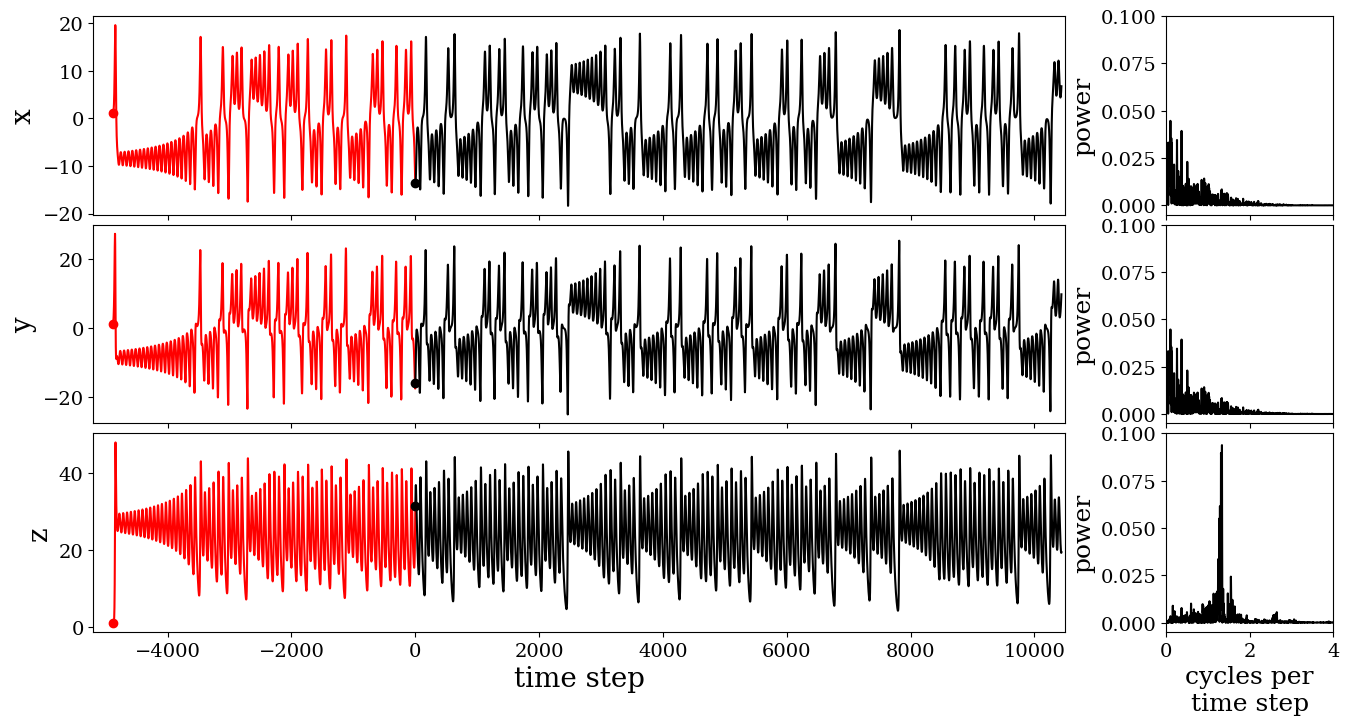

In [40]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(3,5)

xax = fig.add_subplot(gs[0,0:4])
yax = fig.add_subplot(gs[1,0:4])
zax = fig.add_subplot(gs[2,0:4])

xls = fig.add_subplot(gs[0,4])
yls = fig.add_subplot(gs[1,4])
zls = fig.add_subplot(gs[2,4])

axes = [xax,yax,zax]
for i in range(3):
    axes[i].plot((lorenz_t_init[0]+450+(5000-4881)/100)/dt,lorenz_r_init[0,i],'ro',zorder=2)
    #axes[i].plot(lorenz_t_init[:5000]+450,lorenz_r_init[:5000,i],'r-')
    # this shadiness is because when I went back to add the power spectra to the Lorenz plot, suddenly I was getting
    # a different result for the numerical integration from scipy RK45 (i.e. lorenz_r[5000] was different, diverging from
    # my previous trajectory at about time step 4000. It doesn't matter for the subsequent analysis; I've still chosen
    # an initial point safely on the attractor and am integrating onward from there, but the plot does need to line up.
    axes[i].plot((lorenz_t_init[:4881]+450+(5000-4881)/100)/dt,lorenz_r_init[:4881,i],'r-',zorder=1)
    axes[i].plot(lorenz_t[0]/dt, lorenz_r[0,i],'ko',zorder=4)
    axes[i].plot(lorenz_t/dt, lorenz_r[:,i],'k-',zorder=3)

xax.set_ylabel("x",fontsize=20)
yax.set_ylabel("y",fontsize=20)
zax.set_ylabel("z",fontsize=20)

zax.set_xlabel("time step",fontsize=20)
xax.set_xticklabels([])
yax.set_xticklabels([])

for ax in axes:
    ax.tick_params(labelsize=14)
    ax.set_xlim(-52/dt,105/dt)

xfreq, xpow = LombScargle(lorenz_t,lorenz_r[:,0]).autopower(minimum_frequency=1./(lorenz_t[-1] - lorenz_t[0]), maximum_frequency=1./(2.*dt))
xls.plot(xfreq,xpow,'k-')
#xls.set_xlabel("cycles per time step, dt = 0.1",fontsize=20)
xls.set_ylabel("power",fontsize=18)

yfreq, ypow = LombScargle(lorenz_t,lorenz_r[:,1]).autopower(minimum_frequency=1./(lorenz_t[-1] - lorenz_t[0]), maximum_frequency=1./(2.*dt))
yls.plot(xfreq,xpow,'k-')
#yls.set_xlabel("cycles per time step, dt = 0.1",fontsize=20)
yls.set_ylabel("power",fontsize=18)

zfreq, zpow = LombScargle(lorenz_t,lorenz_r[:,2]).autopower(minimum_frequency=1./(lorenz_t[-1] - lorenz_t[0]), maximum_frequency=1./(2.*dt))
zls.plot(zfreq,zpow,'k-')
zls.set_xlabel("cycles per\ntime step",fontsize=18)
zls.set_ylabel("power",fontsize=18)

xls.set_xticklabels([])
yls.set_xticklabels([])
for ax in [xls,yls,zls]:
    ax.set_xlim(0.,4)
    ax.set_ylim(-0.005,0.1)
    ax.tick_params(labelsize=14)
    #ax.set_yscale("log")
    #ax.set_xscale("log")
 
plt.subplots_adjust(hspace=0.05,wspace=0.6)
#plt.show()
plt.savefig("./lorenz_timeseries.pdf",bbox_inches="tight")

## Showing perfect, noisy+gapless, noiseless+gappy, realistic versions of the Lorenz x time series.

In [47]:
pwd

'/Users/Emily/Documents/astro/starspot_chaos/realistic_synthetic_data'

In [48]:
perfect = np.genfromtxt("./data/4_rossler/4_rossler_x_speculoos_perfect.txt")
gaps = np.genfromtxt("./data/4_rossler/4_rossler_x_speculoos_gaps.txt")

#perfect_kepler = np.genfromtxt("./data/4_rossler/4_rossler_x_kepler_perfect.txt")
#perfect_tess = np.genfromtxt("./data/4_rossler/4_rossler_x_tess_perfect.txt")

#print(np.shape(perfect))
#print(np.shape(perfect_kepler))
#print(np.shape(perfect_tess))

In [49]:
print(np.shape(perfect))
print(np.shape(gaps))

(44119, 4)
(6757, 4)


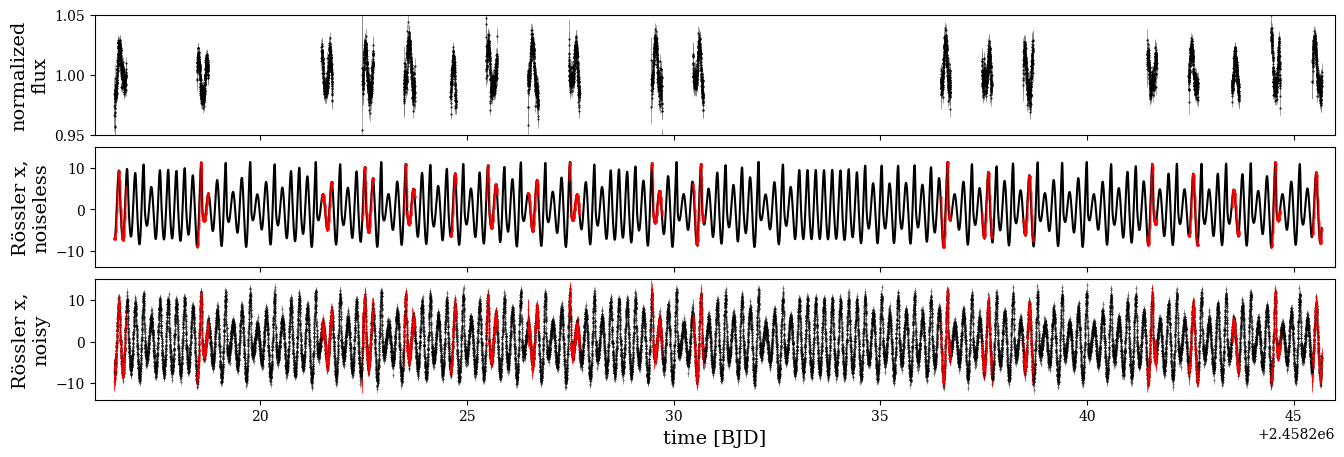

In [50]:
fig, axes = plt.subplots(3,1,figsize=(16,5),sharex=True)
axes[0].errorbar(speculoos_trunc[:,0],speculoos_trunc[:,1],yerr=speculoos_trunc[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')

axes[1].plot(perfect[:,0],perfect[:,1],'k-')
axes[2].errorbar(perfect[:,0],perfect[:,2],yerr=perfect[:,3],color='k',marker='.',capsize=0,elinewidth=0.5,linestyle='None',ms=0.5,ecolor='Gray')
axes[1].plot(gaps[:,0],gaps[:,1],'r.',ms=0.5)
axes[2].errorbar(gaps[:,0],gaps[:,2],yerr=gaps[:,3],color='r',marker='.',capsize=0,elinewidth=0.5,linestyle='None',ms=0.5,ecolor='r')
for ax in axes:
    ax.set_xlim(2458216,2458246)
for ax in axes[1:]:    
    ax.set_ylim(-14,15)
axes[1].set_ylabel("Rössler x,\nnoiseless",fontsize=14)
axes[2].set_ylabel("Rössler x,\nnoisy",fontsize=14)
axes[2].set_xlabel('time [BJD]',fontsize=14)
axes[0].set_ylabel('normalized\nflux',fontsize=14)
axes[0].set_ylim(0.95,1.05)
plt.subplots_adjust(hspace=0.1)
#plt.show()
plt.savefig("./rossler_x_addednoise.pdf",bbox_inches="tight")

In [51]:
# normalize data to run between 0 and 1
gapless_perfect_ts = (perfect[:,1] - np.min(perfect[:,1]))/np.ptp(perfect[:,1])
gapless_noisy_ts = (perfect[:,2] - np.min(perfect[:,1]))/np.ptp(perfect[:,1])
gapless_noisy_err = perfect[:,3]/np.ptp(perfect[:,1])


gappy_perfect_ts = (gaps[:,1] - np.min(gaps[:,1]))/np.ptp(gaps[:,1])
gappy_noisy_ts = (gaps[:,2] - np.min(gaps[:,1]))/np.ptp(gaps[:,1])
gappy_noisy_err = gaps[:,3]/np.ptp(gaps[:,1])


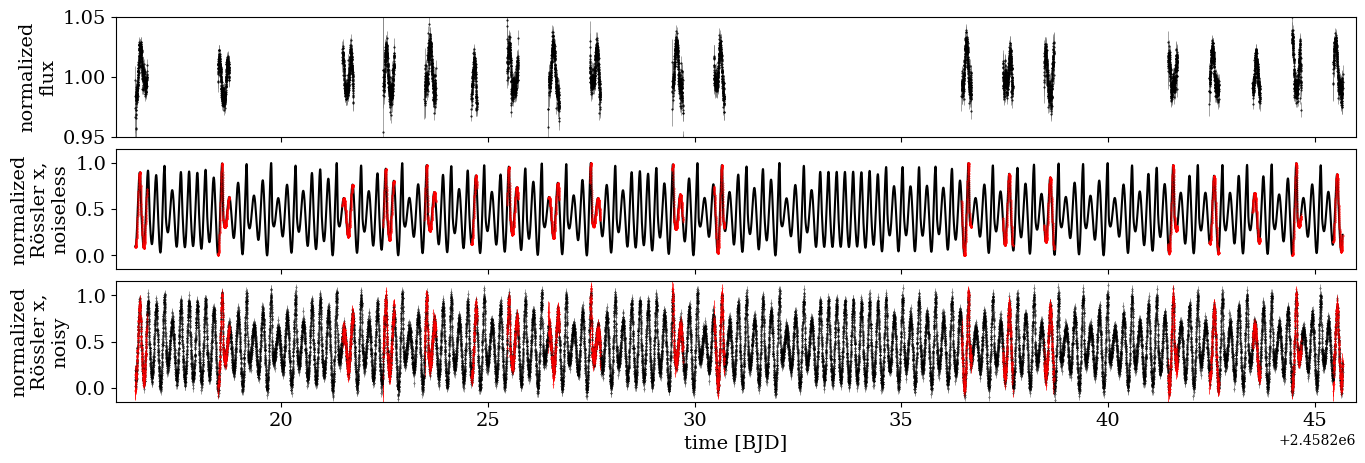

In [55]:
fig, axes = plt.subplots(3,1,figsize=(16,5),sharex=True)
axes[0].errorbar(speculoos_trunc[:,0],speculoos_trunc[:,1],yerr=speculoos_trunc[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')

axes[1].plot(perfect[:,0],gapless_perfect_ts,'k-')
axes[2].errorbar(perfect[:,0],gapless_noisy_ts,yerr=gapless_noisy_err,color='k',marker='.',capsize=0,elinewidth=0.5,linestyle='None',ms=0.5,ecolor='Gray')
axes[1].plot(gaps[:,0],gappy_perfect_ts,'r.',ms=0.5)
axes[2].errorbar(gaps[:,0],gappy_noisy_ts,yerr=gappy_noisy_err,color='r',marker='.',capsize=0,elinewidth=0.5,linestyle='None',ms=0.5,ecolor='r')
for ax in axes:
    ax.set_xlim(2458216,2458246)
for ax in axes[1:]:    
    ax.set_ylim(-0.15,1.15)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)
    
axes[1].set_ylabel("normalized\nRössler x,\nnoiseless",fontsize=14)
axes[2].set_ylabel("normalized\nRössler x,\nnoisy",fontsize=14)
axes[2].set_xlabel('time [BJD]',fontsize=14)
axes[0].set_ylabel('normalized\nflux',fontsize=14)
axes[0].set_ylim(0.95,1.05)
plt.subplots_adjust(hspace=0.1)
#plt.show()
plt.savefig("./rossler_x_addednoise_normalized.pdf",bbox_inches="tight")